In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset as TorchDataset
from tqdm import tqdm
from datasets import Dataset
from datetime import datetime

In [2]:
torch.cuda.is_available()

True

In [3]:
def merge_and_stat_label(folder_path):
    all_dfs = []
    for filename in tqdm(os.listdir(folder_path)):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            all_dfs.append(df)
    merged_df = pd.concat(all_dfs, ignore_index=True)
    label_stats = merged_df['Label'].value_counts()
    return merged_df, label_stats

# Filter the dataset based on minimum label count
def filter_by_min_count(df, label_column, min_count):
    label_counts = df[label_column].value_counts()
    valid_labels = label_counts[label_counts >= min_count].index
    return df[df[label_column].isin(valid_labels)]

# Create Hugging Face Dataset from raw data
def create_huggingface_dataset(X, y, X_matrix, column_matrix):
    data = []
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Process each row of data
    for i in tqdm(range(len(X))):
        x_value = X[i]  # Row in X
        attack_name = y_encoded[i]
        
        # Map X[i] values to X_matrix and column_matrix (index-based)
        X_transformed = np.concatenate([X_matrix[x_value], column_matrix])
        
        data.append({"features": X_transformed, "label": attack_name})

    return Dataset.from_dict({
        "features": [x["features"] for x in data],
        "label": [x["label"] for x in data]
    }), y_encoded, le

In [4]:
folder_path = 'Datasets/TabularIoTAttacks-2024'

# Load and filter dataset
merged_df, label_stats = merge_and_stat_label(folder_path)
min_count = 32620
filtered_df = filter_by_min_count(merged_df, 'Attack Name', min_count)




100%|██████████| 15/15 [00:37<00:00,  2.50s/it]


In [5]:
# Extract X and y
y = filtered_df['Attack Name']
X = filtered_df.select_dtypes(include=['int64', 'float64'])
X = X.drop(columns=['Label', 'Src Port', 'Dst Port', 'Protocol'], axis=1)

In [6]:
scaler = MinMaxScaler(feature_range=(0, 50000))
scaled_X = scaler.fit_transform(X)

# Create random X_matrix and column_matrix (example, replace with actual data)
X_matrix = np.random.rand(50000+1, 64)  # Replace with actual X_matrix
column_matrix = np.random.rand(76, 64)  # Replace with actual column_matrix
scaled_X = scaled_X.astype(int)

In [7]:
X_matrix.dtype, column_matrix.dtype, scaled_X.dtype

(dtype('float64'), dtype('float64'), dtype('int64'))

In [8]:
import numpy as np

def process_input_and_generate_result(scaled_X, X_matrix, column_matrix):
    """
    Hàm nhận vào ma trận X và trả về kết quả tương ứng.
    
    :param X: Ma trận X chứa các chỉ số (index) để truy cập vào X_matrix và column_matrix
    :param scaled_X: Ma trận scaled_X chứa các chỉ số để truy cập vào các giá trị trong X_matrix
    :param X_matrix: Ma trận dữ liệu dùng để truy xuất theo các chỉ số từ scaled_X
    :param column_matrix: Ma trận cột dùng để kết hợp với các giá trị từ X_matrix
    :return: Ma trận kết quả đã được điền dữ liệu từ X_matrix và column_matrix
    """
    
    # Tạo file nhớ ảo trên đĩa
    result = np.zeros((scaled_X.shape[0], scaled_X.shape[1], X_matrix.shape[1] + column_matrix.shape[1]))  # (195720, 76, 128)

    # Điền giá trị cho result trong vòng lặp
    for i in range(scaled_X.shape[0]):
        for j in range(scaled_X.shape[1]):
            x_value = X_matrix[scaled_X[i, j]]
            column_value = column_matrix[j]
            result[i, j] = np.concatenate((x_value, column_value))

    # Trả về kết quả
    return result

# Ví dụ sử dụng hàm
result = process_input_and_generate_result(scaled_X[:10], X_matrix, column_matrix)


In [9]:
import numpy as np

def process_input_and_generate_result_tensor(scaled_X, X_matrix, column_matrix):
    
    result = torch.zeros((scaled_X.shape[0], scaled_X.shape[1], X_matrix.shape[1] + column_matrix.shape[1]))  # (195720, 76, 128)

    for i in range(scaled_X.shape[0]):
        for j in range(scaled_X.shape[1]):
            x_value = X_matrix[scaled_X[i, j]]
            column_value = column_matrix[j]
            result[i, j] = torch.concatenate((x_value, column_value))

    return result

In [10]:
scaled_X[:10].shape

(10, 76)

In [11]:
result.shape

(10, 76, 128)

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [13]:
result.shape, y_encoded.shape

((10, 76, 128), (3362319,))

In [14]:
le.classes_ 

array(['Benign Traffic', 'DoS TCP Flood', 'MQTT DDoS Publish Flood',
       'MQTT DoS Connect Flood', 'Recon OS Scan', 'Recon Port Scan'],
      dtype=object)

In [15]:
def collate_fn(batch):
    """
    Collate function to process data with process_input_and_generate_result.
    
    :param batch: A batch of data (inputs, targets)
    :return: Processed batch (inputs, targets)
    """
    inputs, targets = zip(*batch)  # Tách dữ liệu và nhãn

    # Chuyển danh sách inputs thành một tensor 3D, có shape: (batch_size, seq_len, input_size)
    inputs = torch.stack(inputs, dim=0)
    targets = torch.tensor(targets, dtype=torch.long)

    # Giả sử bạn đã có sẵn scaled_X, X_matrix, và column_matrix
    # Chuyển đổi dữ liệu sử dụng hàm process_input_and_generate_result
    processed_inputs = process_input_and_generate_result(inputs.numpy(), X_matrix, column_matrix)
    
    # Chuyển processed_inputs về dạng tensor
    processed_inputs = torch.tensor(processed_inputs, dtype=torch.float32)
    
    return processed_inputs, targets


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Import tqdm để sử dụng progress bar
from torch.utils.tensorboard import SummaryWriter  # Import TensorBoard writer
from model import CNNClassifier

# Giả sử dữ liệu của bạn đã có sẵn
# result: Dữ liệu đầu vào (195720, 76, 128)
# y_encoded: Nhãn mục tiêu đã được mã hóa sẵn (195720, )

# result = np.random.rand(195720, 76, 128)  # Ví dụ về dữ liệu đầu vào (có thể thay thế bằng dữ liệu thật)
# y_encoded = np.random.randint(0, 6, size=(195720,))  # Ví dụ về nhãn mục tiêu với 6 lớp (0-5)

# Kiểm tra giá trị duy nhất trong y_encoded
print(np.unique(y_encoded))  # Đảm bảo giá trị chỉ là 0, 1, 2, 3, 4, 5

# Kiểm tra xem có GPU có thể sử dụng không
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Chuyển dữ liệu sang tensor PyTorch và chuyển sang GPU nếu có
X_tensor = torch.tensor(scaled_X, dtype=torch.long)  # Tensor đầu vào
y_tensor = torch.tensor(y_encoded, dtype=torch.long)  # Tensor nhãn mục tiêu (dạng long cho phân loại)

# Chia dữ liệu thành train, validation và test
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.4, random_state=42, stratify=y_tensor)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Các tham số mô hình
input_size = 128  # Kích thước của mỗi đầu vào (sau khi nối X_matrix và column_matrix)
hidden_size = 64  # Kích thước của hidden layer
num_layers = 2  # Số lớp LSTM
num_classes = len(np.unique(y_encoded)) 
sequence_length = X_train.shape[1]  # Độ dài của mỗi chuỗi dữ liệu

# Khởi tạo mô hình, loss function và optimizer
model = CNNClassifier(input_size, sequence_length, num_classes)
model.to(device)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss cho phân loại đa lớp
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer Adam

# Định nghĩa DataLoader cho train, validation và test set
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

batch_size = 256 * 2
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)



[0 1 2 3 4 5]
Using device: cuda


In [27]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
log_dir = f'./logs/{timestamp}'
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

In [28]:
# save X_matrix and column_matrix, scaled_X, y_encoded, le, scaler
np.save(os.path.join(log_dir, 'X_matrix.npy'), X_matrix)
np.save(os.path.join(log_dir, 'column_matrix.npy'), column_matrix)
np.save(os.path.join(log_dir, 'scaled_X.npy'), scaled_X)
np.save(os.path.join(log_dir, 'y_encoded.npy'), y_encoded)
import joblib

joblib.dump(le, os.path.join(log_dir, 'label_encoder.joblib'))
joblib.dump(scaler, os.path.join(log_dir, 'min_max_scaler.joblib'))

['./logs/20241208_012214\\min_max_scaler.joblib']

In [29]:
print(model)

CNNClassifier(
  (conv1): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2432, out_features=6, bias=True)
)


In [30]:


# Đào tạo mô hình
num_epochs = 5
for epoch in range(num_epochs):
    model.train()  # Đặt mô hình vào chế độ huấn luyện
    epoch_loss = 0
    correct_train = 0
    total_train = 0
    
    # Sử dụng tqdm để thêm progress bar vào vòng lặp batch
    with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)  # Chuyển inputs và targets sang GPU
            
            # Forward pass
            outputs = model(inputs)  # Lấy đầu ra của mô hình
            
            # Tính loss
            loss = criterion(outputs, targets)
            
            # Backward pass và tối ưu
            optimizer.zero_grad()  # Xoá gradient cũ
            loss.backward()  # Tính gradient
            optimizer.step()  # Cập nhật tham số
            
            epoch_loss += loss.item()

            # Tính accuracy trên tập train
            _, predicted = torch.max(outputs, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()

            # Cập nhật tiến trình
            pbar.set_postfix(loss=epoch_loss / (total_train / 64), accuracy=100 * correct_train / total_train)  # Cập nhật tiến trình
            pbar.update(1)  # Cập nhật progress bar
    
    # Tính accuracy và log vào TensorBoard
    train_accuracy = 100 * correct_train / total_train
    print(f"Train Loss: {epoch_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Log loss and accuracy to TensorBoard
    writer.add_scalar('Loss/train', epoch_loss / len(train_loader), epoch)
    writer.add_scalar('Accuracy/train', train_accuracy, epoch)

    # Kiểm tra accuracy trên tập validation
    model.eval()  # Chuyển mô hình sang chế độ đánh giá
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Chuyển sang GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()
    
    val_accuracy = 100 * correct_val / total_val
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    
    # Log validation accuracy to TensorBoard
    writer.add_scalar('Accuracy/val', val_accuracy, epoch)

    # Save model checkpoint after each epoch
    model_save_path = os.path.join(log_dir, f'model_epoch_{epoch+1}.pth')
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved at {model_save_path}")



Epoch 1/5:   0%|          | 0/3941 [00:00<?, ?batch/s]

Epoch 1/5: 100%|██████████| 3941/3941 [14:19<00:00,  4.59batch/s, accuracy=96.7, loss=0.00981]


Train Loss: 0.0785, Train Accuracy: 96.74%
Validation Accuracy: 97.25%
Model saved at ./logs/20241208_012214\model_epoch_1.pth


Epoch 2/5: 100%|██████████| 3941/3941 [13:36<00:00,  4.83batch/s, accuracy=97.2, loss=0.00781]


Train Loss: 0.0624, Train Accuracy: 97.23%
Validation Accuracy: 97.26%
Model saved at ./logs/20241208_012214\model_epoch_2.pth


Epoch 3/5: 100%|██████████| 3941/3941 [13:42<00:00,  4.79batch/s, accuracy=97.2, loss=0.00765]


Train Loss: 0.0612, Train Accuracy: 97.25%
Validation Accuracy: 97.28%
Model saved at ./logs/20241208_012214\model_epoch_3.pth


Epoch 4/5: 100%|██████████| 3941/3941 [13:34<00:00,  4.84batch/s, accuracy=97.3, loss=0.00756]


Train Loss: 0.0605, Train Accuracy: 97.28%
Validation Accuracy: 97.29%
Model saved at ./logs/20241208_012214\model_epoch_4.pth


Epoch 5/5: 100%|██████████| 3941/3941 [13:28<00:00,  4.88batch/s, accuracy=97.3, loss=0.0075] 


Train Loss: 0.0600, Train Accuracy: 97.28%
Validation Accuracy: 97.28%
Model saved at ./logs/20241208_012214\model_epoch_5.pth


In [31]:
# After training, evaluate on test set once
model.eval()  # Ensure model is in evaluation mode
correct_test = 0
total_test = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Chuyển sang GPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_test += targets.size(0)
        correct_test += (predicted == targets).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.2f}%")

# In classification report
print("Classification Report on Test Set:")
print(classification_report(all_labels, all_preds))

# Log test accuracy to TensorBoard
writer.add_scalar('Accuracy/test', test_accuracy)
writer.close()

Test Accuracy: 97.31%
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      6524
           1       1.00      1.00      1.00    421384
           2       0.98      1.00      0.99     82782
           3       1.00      0.97      0.98     47606
           4       0.58      0.23      0.33     17064
           5       0.88      0.97      0.92     97104

    accuracy                           0.97    672464
   macro avg       0.90      0.86      0.87    672464
weighted avg       0.97      0.97      0.97    672464



In [32]:
print(classification_report(all_labels, all_preds, target_names=np.delete(le.classes_, 4), digits=4, labels=[0, 1, 2, 3, 5]))

                         precision    recall  f1-score   support

         Benign Traffic     0.9495    0.9914    0.9700      6524
          DoS TCP Flood     0.9999    0.9995    0.9997    421384
MQTT DDoS Publish Flood     0.9799    0.9988    0.9893     82782
 MQTT DoS Connect Flood     0.9965    0.9652    0.9806     47606
        Recon Port Scan     0.8784    0.9700    0.9220     97104

              micro avg     0.9771    0.9924    0.9847    655400
              macro avg     0.9609    0.9850    0.9723    655400
           weighted avg     0.9786    0.9924    0.9852    655400



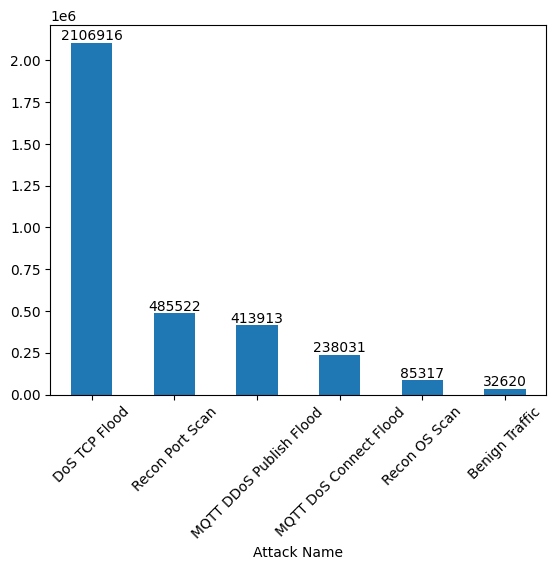

In [ ]:
import matplotlib.pyplot as plt

ax = y.value_counts().plot(kind='bar')

# Add annotations for each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Rotate X-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()


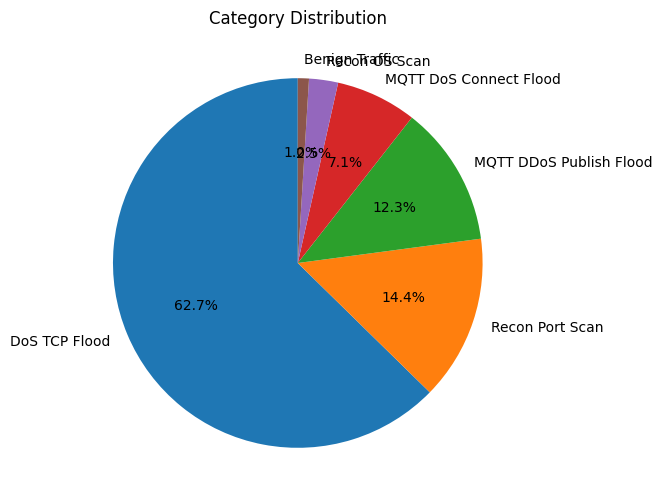

In [ ]:
value_counts = y.value_counts()

# Plot the pie chart with labels and values
plt.figure(figsize=(6, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)

# Add title
plt.title("Category Distribution")

# Show the plot
plt.show()